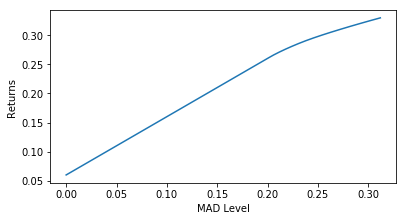

In [6]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import gurobipy 
import operator
import functools

def sumproduct(*lists):
    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))
#***************INPUTS**********************************************************************************
# enter the cov matrix as a 2-D array
cov = np.array([[0.0784,0.03413256,0.0172368],[0.03413256,0.1089,0.0283536],[0.0172368,0.0283536,0.16]])
# enter return matrix as a 1D array
ret = np.array([0.2,0.18,.33])
Rf = 0.06 # Risk free rate
SIM = 3000 #it does 'opts' no of optimizations each with ~ SIM variables and ~ 2*SIM constraints. takes abt 3-4 mins.
return_limits=[min(np.amin(ret), Rf), max(np.amax(ret), Rf)] # provide min and max level of retrun to minimize the MAD
opts= 56 # no of levels of CVAR considered at which an optimization is performed
#########################################################################################################
#adding Riskfree as an asset in the mix in both the cov as well as return matrices
C1 = np.concatenate((cov, np.zeros(len(ret)).reshape(1,len(ret))), axis =0)
col = np.zeros(len(ret) +1 )
cov = np.concatenate((C1, col.reshape(len(ret)+1, 1)), axis =1)
ret = np.append(ret,Rf)
########################################################################################################
# create random return samples of assets that follow a given VC structure
np.random.seed(3) # using a specific seed for ctrl and tst cases, you can change it or remove for running random samples
x = np.random.multivariate_normal(ret, cov, SIM) # simulated "SIM" no of returns of the assets
########################################################################################################
minret = return_limits[0]
maxret = return_limits[1]
mulevel = cp.Parameter(nonneg=True)
w = cp.Variable(len(ret)) # weights of allocation among all diff assets including cash
u = cp.Variable(len(x))
mu = sumproduct(w,ret)
con=[]
for i in range(len(x)):
    con.append( u[i]-sumproduct(w,x[i])+ mu >=0)
    con.append( u[i]+sumproduct(w,x[i])- mu >=0)
    
con.append(cp.sum(w) == 1)
con.append(w>=0)
con.append(u>=0)
con.append(mu >= mulevel)
prob = cp.Problem(cp.Minimize(1/len(x)*cp.sum(u)), con) # this is the MAD for the portfolio

#########################################################################################################
Return =[]
Risk =[]
level=[]
param = np.linspace(minret, maxret, opts)
Allocation = np.empty((len(np.linspace(minret,maxret, opts)), len(ret)))
for p,val in enumerate(param):
    mulevel.value = val
    prob.solve(solver = cp.GLPK)
    Return.append(val)
    for i in range(len(ret)):
        Allocation[p][i]= w.value[i]
    Risk.append(np.sqrt(sumproduct(np.matmul(Allocation[p].T, cov), Allocation[p])))
    level.append(prob.value)
    
    
#getting allocations in excel
import xlsxwriter
Return = np.array(Return)
Allocation = np.array(Allocation)
level = np.array(level)
Risk = np.array(Risk)
output = np.array(list(zip(Allocation[:,0], Allocation[:,1], Allocation[:,2], Allocation[:,3],Return, Risk,level)))

workbook = xlsxwriter.Workbook('MAD.xlsx')
worksheet = workbook.add_worksheet()
row = 0
for col, data in enumerate(output):
    worksheet.write_row(col, row, data)
workbook.close()                      
                     
############################################################################################################################
fig = plt.figure()
ax1 = fig.add_axes((0.1,0.3,0.8,0.6)) # create an Axes with some room below

X = level
Y = Return

ax1.plot(X,Y)
ax1.set_xlabel(r"MAD Level")
ax1.set_ylabel(r"Returns")


plt.show()
#############################################################################################################################
